<a href="https://colab.research.google.com/github/hockyy/food-101-mlcv/blob/main/FoodHockyExplore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

def import_from_google_drive():
  drive.mount('/content/drive')

In [19]:
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

def makedir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def organize_data():
  food_prefix = "/content/mlcv/food-101"
  food_organized_prefix = "/content/mlcv/food-101-ok"
  split_count = food_prefix.count('/')
  food_path = f"{food_prefix}/*"
  food_directories = glob.glob(food_path)
  food_directories = [dir for dir in food_directories if ("test" not in dir) and ("validate" not in dir) and ("train" not in dir)]
  classes = []
  classes_map = dict()
  for food_directory in food_directories:
    food_name = food_directory.split('/')[split_count + 1]
    # Map each food name to each index
    current_label = len(classes)
    classes_map[food_name] = current_label
    classes.append(food_name)
    print(f"Organizing {food_directory}")
    filenames = glob.glob(f"{food_directory}/*.jpg")
    train, validate, test = np.split(filenames, [int(len(filenames)*0.8), int(len(filenames)*0.9)])
    print(food_name)
    os.makedirs(f"{food_organized_prefix}/train/{food_name}",exist_ok=True)
    os.makedirs(f"{food_organized_prefix}/validate/{food_name}",exist_ok=True)
    os.makedirs(f"{food_organized_prefix}/test/{food_name}",exist_ok=True)
    for food_file in train:
      food_image_name = food_file.split("/",split_count + 1)
      try:
        shutil.move(food_file, f"{food_organized_prefix}/train/{food_image_name[-1]}")
      except Exception as e:
        print(e)
    for food_file in validate:
      food_image_name = food_file.split("/",split_count + 1)
      try:
        shutil.move(food_file, f"{food_organized_prefix}/validate/{food_image_name[-1]}")
      except Exception as e:
        print(e)
    for food_file in test:
      food_image_name = food_file.split("/",split_count + 1)
      try:
        shutil.move(food_file, f"{food_organized_prefix}/test/{food_image_name[-1]}")
      except Exception as e:
        print(e)

  return classes, classes_map

In [18]:
def create_image_generator(image_size):
  food_organized_prefix = "/content/mlcv/food-101-ok"
  train_path = f"{food_organized_prefix}/train"
  validate_path = f"{food_organized_prefix}/validate"
  test_path = f"{food_organized_prefix}/test"
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)
  validate_datagen = ImageDataGenerator(rescale=1./255)
  image_shape_target = (image_size,image_size)
  train_generator = train_datagen.flow_from_directory(
          train_path,
          target_size=image_shape_target,
          color_mode="rgb",
          class_mode="categorical",
          shuffle=False,
          batch_size=32)
  test_generator = test_datagen.flow_from_directory(
          test_path,
          target_size=image_shape_target,
          color_mode="rgb",
          class_mode="categorical",
          shuffle=False,
          batch_size=1)
  validate_generator = validate_datagen.flow_from_directory(
          validate_path,
          target_size=image_shape_target,
          color_mode="rgb",
          class_mode="categorical",
          shuffle=False,
          batch_size=1)
  return train_generator, validate_generator, test_generator

In [43]:
def load_model_and_checkpoint(model_name):
  checkpoint_path = f"{model_name}/cp.ckpt"
  try:
    model = tf.keras.models.load_model(model_name)
    model.load_weights(checkpoint_path)
    return model
  except:
    return None

def train_or_load_model(model, generator, model_name, epochs=10):
  checkpoint_path = f"{model_name}/cp.ckpt"
  loaded_model = load_model_and_checkpoint(model_name)
  if(loaded_model is not None):
    model = loaded_model
  else:
    model.save(model_name)
  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
  model.fit(train_gen, epochs = epochs,callbacks=[cp_callback])
  return model

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

from tensorflow.keras.callbacks import EarlyStopping

def train_or_load_model_early_stopping(model, generator, validation_generator, model_name, epochs=10):
  # assert(model_name.endswith(".h5"))
  checkpoint_path = f"{model_name}/cp.ckpt"
  loaded_model = load_model_and_checkpoint(model_name)
  if(loaded_model is not None):
    model = loaded_model
  else:
    model.save(f"{model_name}")
  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
  es_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
  history = model.fit(train_gen, epochs = epochs,callbacks=[cp_callback, es_callback], validation_data=validation_generator)
  plot_metric(history, "loss")
  return model



In [7]:
def save_model_to_drive(model_name):
  try:
    shutil.rmtree(f"/content/drive/MyDrive/mlcv/{model_name}")
  except:
    pass
  shutil.copytree(f"/content/{model_name}", f"/content/drive/MyDrive/mlcv/{model_name}")

In [8]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def predict_and_assess_model(model, test_generator):
  result = model.predict(test_generator)
  # Gives each class a probability, prediction is the max index
  y_pred_classes = [np.argmax(element) for element in result]
  y_test = test_generator.classes
  # print(test_generator.classes)
  print("Classification Report: \n", classification_report(y_test, y_pred_classes))
  plt.figure(figsize=(15,15))
  ax = plt.subplot(1,1,1)
  cm = confusion_matrix(y_test, y_pred_classes)
  disp = ConfusionMatrixDisplay(cm, display_labels=classes_food_101)
  disp.plot(ax=ax)
  plt.show()


In [22]:
import_from_google_drive()

!cp -r "/content/drive/MyDrive/mlcv/" "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
classes_food_101, classes_map_food_101 = organize_data()

Organizing /content/mlcv/food-101/takoyaki
takoyaki
Organizing /content/mlcv/food-101/garlic_bread
garlic_bread
Organizing /content/mlcv/food-101/gnocchi
gnocchi
Organizing /content/mlcv/food-101/donuts
donuts
Organizing /content/mlcv/food-101/bread_pudding
bread_pudding
Organizing /content/mlcv/food-101/samosa
samosa
Organizing /content/mlcv/food-101/sashimi
sashimi
Organizing /content/mlcv/food-101/chicken_curry
chicken_curry
Organizing /content/mlcv/food-101/spaghetti_carbonara
spaghetti_carbonara
Organizing /content/mlcv/food-101/seaweed_salad
seaweed_salad


In [ ]:
# Delete organized folders
!rm -rf "/content/mlcv/food-101"

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

def LeNet():
  model = Sequential([
    # CNN Layer
    layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)),
    layers.AveragePooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    layers.AveragePooling2D(),
    layers.Flatten(),

    # Dense Layer
    layers.Dense(units=120, activation='relu'),
    layers.Dense(units=84, activation='relu'),
    layers.Dense(units=10, activation = 'softmax'),
  ])
  return model


In [49]:
!rm -rf "/content/lenet"

Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
INFO:tensorflow:Assets written to: lenet/assets
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 2.3107 - accuracy: 0.0755
Epoch 1: saving model to lenet/cp.ckpt
250/250 [==============================] - 66s 261ms/step - loss: 2.3107 - accuracy: 0.0755 - val_loss: 2.2948 - val_accuracy: 0.1050
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 2.3008 - accuracy: 0.1014
Epoch 2: saving model to lenet/cp.ckpt
250/250 [==============================] - 69s 276ms/step - loss: 2.3008 - accuracy: 0.1014 - val_loss: 2.2821 - val_accuracy: 0.2060
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 2.2880 - accuracy: 0.1311
Epoch 3: saving model to lenet/cp.ckpt
250/250 [==============================] - 59s 235ms/step - loss: 2.2880 - accuracy: 0.1311 - val_loss: 2.2545 - val_accuracy: 0.1970
Epoch 4/10
250/2

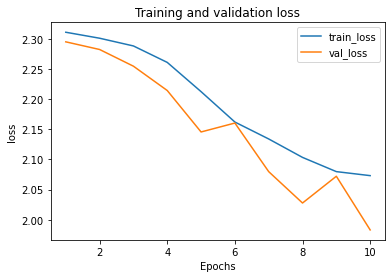

In [50]:
train_gen, test_gen, validate_gen = create_image_generator(32)
lenet = LeNet()
lenet.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
lenet = train_or_load_model_early_stopping(lenet, train_gen, validate_gen, "lenet", 10)


Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 2.0537 - accuracy: 0.2340
Epoch 1: saving model to lenet/cp.ckpt
250/250 [==============================] - 50s 198ms/step - loss: 2.0537 - accuracy: 0.2340 - val_loss: 1.9974 - val_accuracy: 0.2610
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 2.0401 - accuracy: 0.2432
Epoch 2: saving model to lenet/cp.ckpt
250/250 [==============================] - 45s 180ms/step - loss: 2.0401 - accuracy: 0.2432 - val_loss: 1.9634 - val_accuracy: 0.2690
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 2.0279 - accuracy: 0.2464
Epoch 3: saving model to lenet/cp.ckpt
250/250 [==============================] - 49s 196ms/step - loss: 2.0279 - accuracy: 0.2464 - val_loss: 2.3488 - val_accuracy: 0.2080
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 2.0129 - accuracy: 0.2498
Epoch 4: saving model to lenet/cp.ckpt
250/250 [==============================] - 52s 207ms/step 

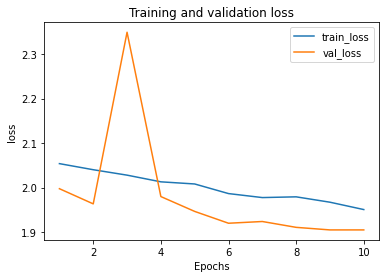

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.9499 - accuracy: 0.2904
Epoch 1: saving model to lenet/cp.ckpt
250/250 [==============================] - 52s 204ms/step - loss: 1.9499 - accuracy: 0.2904 - val_loss: 1.9217 - val_accuracy: 0.3110
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.9244 - accuracy: 0.3000
Epoch 2: saving model to lenet/cp.ckpt
250/250 [==============================] - 51s 203ms/step - loss: 1.9244 - accuracy: 0.3000 - val_loss: 1.9395 - val_accuracy: 0.2910
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 1.9254 - accuracy: 0.3054
Epoch 3: saving model to lenet/cp.ckpt
250/250 [==============================] - 51s 203ms/step - loss: 1.9254 - accuracy: 0.3054 - val_loss: 1.9324 - val_accuracy: 0.2920
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 1.9079 - accuracy: 0.3140
Epoch 4: saving model to lenet/cp.ckpt
250/250 [==============================] - 51s 203ms/step 

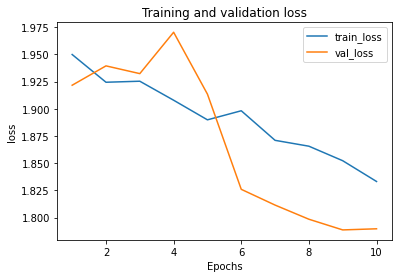

In [54]:
for i in range(2):
  lenet = train_or_load_model_early_stopping(lenet, train_gen, validate_gen, "lenet", 10)
  save_model_to_drive("lenet")

Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.8405 - accuracy: 0.3363
Epoch 1: saving model to lenet/cp.ckpt
250/250 [==============================] - 43s 168ms/step - loss: 1.8405 - accuracy: 0.3363 - val_loss: 1.7785 - val_accuracy: 0.3490
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.8164 - accuracy: 0.3515
Epoch 2: saving model to lenet/cp.ckpt
250/250 [==============================] - 56s 224ms/step - loss: 1.8164 - accuracy: 0.3515 - val_loss: 1.7773 - val_accuracy: 0.3820
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 1.7853 - accuracy: 0.3585
Epoch 3: saving model to lenet/cp.ckpt
250/250 [==============================] - 43s 172ms/step - loss: 1.7853 - accuracy: 0.3585 - val_loss: 1.7683 - val_accuracy: 0.3580
Epoch 4/10
250/250 [==============================] - ETA: 0s - 

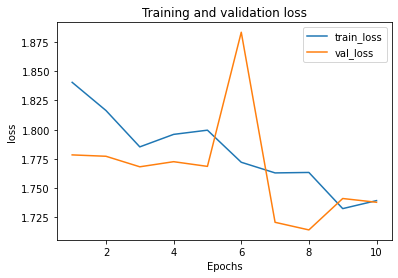

In [56]:
train_gen, test_gen, validate_gen = create_image_generator(32)
lenet = LeNet()
lenet.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
lenet = train_or_load_model_early_stopping(lenet, train_gen, validate_gen, "lenet", 10)


Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.7104 - accuracy: 0.3901
Epoch 1: saving model to lenet/cp.ckpt
250/250 [==============================] - 46s 181ms/step - loss: 1.7104 - accuracy: 0.3901 - val_loss: 1.7356 - val_accuracy: 0.3690
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.7129 - accuracy: 0.3946
Epoch 2: saving model to lenet/cp.ckpt
250/250 [==============================] - 49s 195ms/step - loss: 1.7129 - accuracy: 0.3946 - val_loss: 1.7628 - val_accuracy: 0.3660
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 1.6987 - accuracy: 0.3951
Epoch 3: saving model to lenet/cp.ckpt
250/250 [==============================] - 49s 195ms/step - loss: 1.6987 - accuracy: 0.3951 - val_loss: 1.7858 - val_accuracy: 0.3670
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 1.7021 - accuracy: 0.3954
Epoch 4: saving model to lenet/cp.ckpt
250/250 [==============================] - 44s 177ms/step 

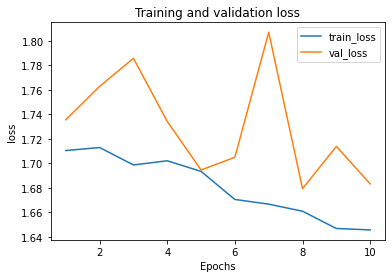

In [58]:
lenet = train_or_load_model_early_stopping(lenet, train_gen, validate_gen, "lenet", 10)

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.6099 - accuracy: 0.4350
Epoch 1: saving model to lenet/cp.ckpt
250/250 [==============================] - 54s 212ms/step - loss: 1.6099 - accuracy: 0.4350 - val_loss: 1.7385 - val_accuracy: 0.3930
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.6058 - accuracy: 0.4320
Epoch 2: saving model to lenet/cp.ckpt
250/250 [==============================] - 48s 190ms/step - loss: 1.6058 - accuracy: 0.4320 - val_loss: 1.7101 - val_accuracy: 0.3840
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 1.5958 - accuracy: 0.4392
Epoch 3: saving model to lenet/cp.ckpt
250/250 [==============================] - 54s 215ms/step - loss: 1.5958 - accuracy: 0.4392 - val_loss: 1.7182 - val_accuracy: 0.4010
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 1.5867 - accuracy: 0.4423
Epoch 4: saving model to lenet/cp.ckpt
250/250 [==============================] - 50s 200ms/step 

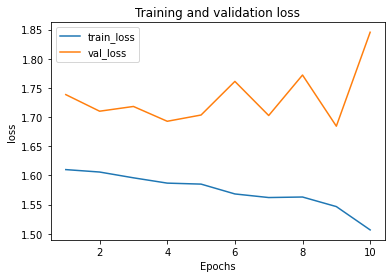

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.5132 - accuracy: 0.4664
Epoch 1: saving model to lenet/cp.ckpt
250/250 [==============================] - 50s 196ms/step - loss: 1.5132 - accuracy: 0.4664 - val_loss: 1.8013 - val_accuracy: 0.3660
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.5145 - accuracy: 0.4627
Epoch 2: saving model to lenet/cp.ckpt
250/250 [==============================] - 44s 175ms/step - loss: 1.5145 - accuracy: 0.4627 - val_loss: 1.7351 - val_accuracy: 0.3680
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 1.4971 - accuracy: 0.4771
Epoch 3: saving model to lenet/cp.ckpt
250/250 [==============================] - 44s 175ms/step - loss: 1.4971 - accuracy: 0.4771 - val_loss: 1.7288 - val_accuracy: 0.3890
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 1.4678 - accuracy: 0.4827
Epoch 4: saving model to lenet/cp.ckpt
250/250 [==============================] - 48s 194ms/step 

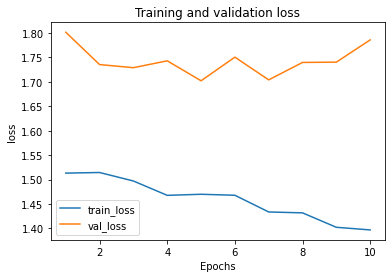

Epoch 1/10
192/250 [======================>.......] - ETA: 8s - loss: 1.3877 - accuracy: 0.5042

KeyboardInterrupt: ignored

In [61]:
for i in range(5):
  lenet = train_or_load_model_early_stopping(lenet, train_gen, validate_gen, "lenet", 10)
  save_model_to_drive("lenet")

Classification Report: 
               precision    recall  f1-score   support

           0       0.32      0.30      0.31       100
           1       0.28      0.37      0.32       100
           2       0.23      0.23      0.23       100
           3       0.42      0.15      0.22       100
           4       0.22      0.21      0.22       100
           5       0.25      0.19      0.21       100
           6       0.62      0.40      0.49       100
           7       0.71      0.80      0.75       100
           8       0.31      0.77      0.44       100
           9       0.26      0.11      0.15       100

    accuracy                           0.35      1000
   macro avg       0.36      0.35      0.33      1000
weighted avg       0.36      0.35      0.33      1000



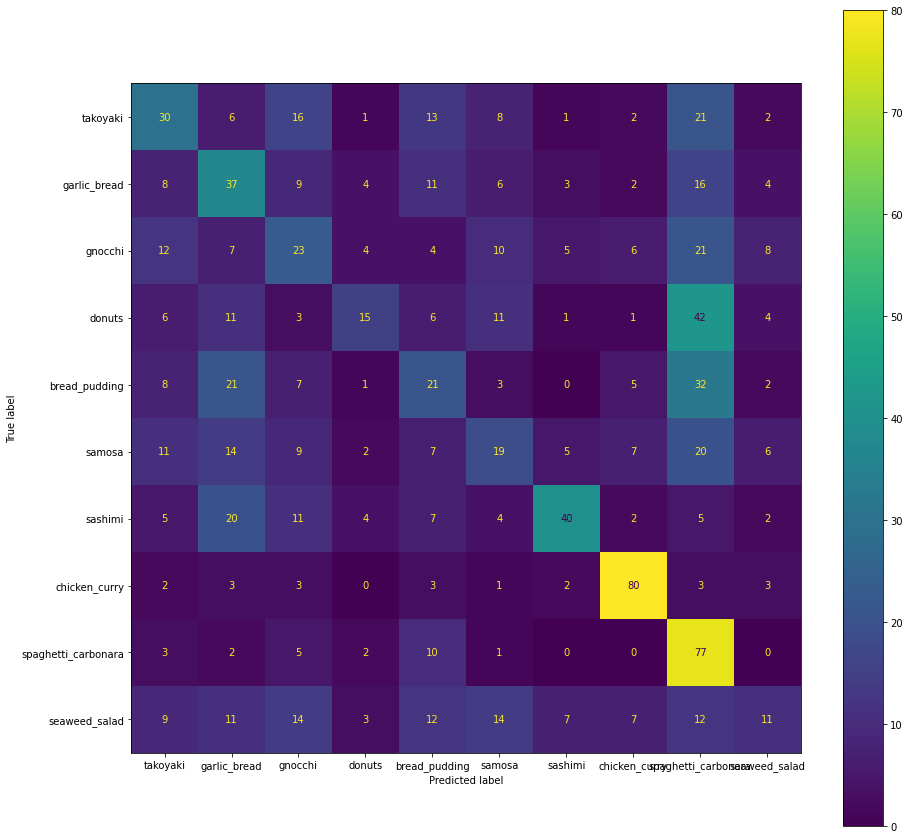

In [62]:
predict_and_assess_model(lenet, test_gen)

In [ ]:
def CobaCobaNet():
  model = Sequential([                  
    # cnn
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(32,32,3)),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    
    # Dense layer  
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax'),
  ])
  return model

In [ ]:
train_gen, test_gen, validate_gen = create_image_generator(32)
cobacobanet = CobaCobaNet()
cobacobanet.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cobacobanet = train_or_load_model_early_stopping(cobacobanet, train_gen, validate_gen, "cobacobanet", 10)


In [29]:
def AlexNet():
  model = Sequential([
    # CNN
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),

    # Dense
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
  ])
  return model



INFO:tensorflow:Assets written to: alexnet/assets
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 5.5942 - accuracy: 0.1051
Epoch 1: saving model to alexnet/cp.ckpt
250/250 [==============================] - 64s 246ms/step - loss: 5.5942 - accuracy: 0.1051 - val_loss: 2.3397 - val_accuracy: 0.1050
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 2.4057 - accuracy: 0.1123
Epoch 2: saving model to alexnet/cp.ckpt
250/250 [==============================] - 63s 253ms/step - loss: 2.4057 - accuracy: 0.1123 - val_loss: 2.2831 - val_accuracy: 0.1510
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 2.3527 - accuracy: 0.1240
Epoch 3: saving model to alexnet/cp.ckpt
250/250 [==============================] - 69s 274ms/step - loss: 2.3527 - accuracy: 0.1240 - val_loss: 2.2933 - val_accuracy: 0.1460
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 2.4028 - accuracy: 0.1250
Epoch 4: saving model to alexnet/cp.ckpt


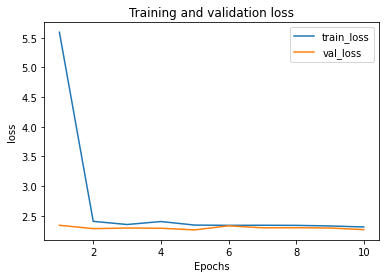

In [118]:
train_gen, test_gen, validate_gen = create_image_generator(227)
alexnet = AlexNet()
alexnet.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
for i in range(10):
  alexnet = train_or_load_model_early_stopping(alexnet, train_gen, validate_gen, "alexnet", 10)
  save_model_to_drive("alexnet")



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.12      0.95      0.21       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.02      0.01      0.01       100
           5       0.09      0.13      0.11       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       100

    accuracy                           0.11      1000
   macro avg       0.02      0.11      0.03      1000
weighted avg       0.02      0.11      0.03      1000



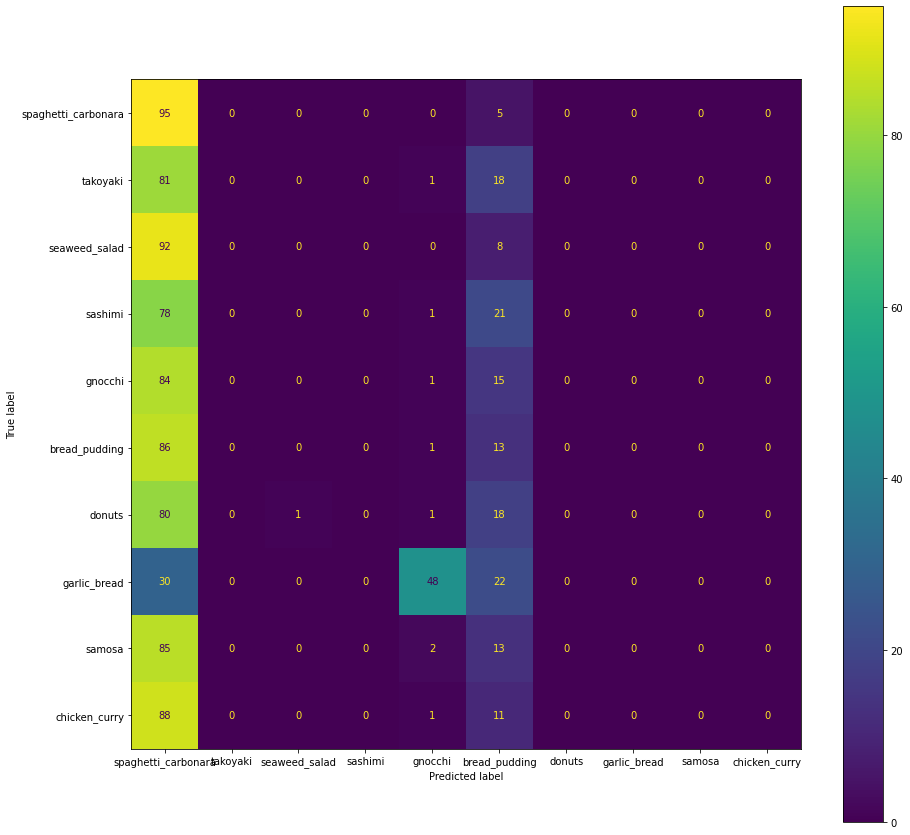

In [126]:
predict_and_assess_model(alexnet, test_gen)

In [133]:

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = layers.Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = layers.Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = layers.Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = layers.Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = layers.Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = layers.MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = layers.Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = layers.concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


def GoogLeNet():
  # input layer 
  input_layer = layers.Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = layers.Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = layers.MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = layers.Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = layers.Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = layers.MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = layers.MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = layers.AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = layers.Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = layers.Flatten()(X1)
  X1 = layers.Dense(1024, activation = 'relu')(X1)
  X1 = layers.Dropout(0.7)(X1)
  X1 = layers.Dense(10, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = layers.AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = layers.Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = layers.Flatten()(X2)
  X2 = layers.Dense(1024, activation = 'relu')(X2)
  X2 = layers.Dropout(0.7)(X2)
  X2 = layers.Dense(10, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = layers.MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = layers.GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = layers.Dropout(0.4)(X)

  # output layer 
  X = layers.Dense(10, activation = 'softmax')(X)
  
  # model
  model = tf.keras.Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
train_gen, test_gen, validate_gen = create_image_generator(224)
googlenet = GoogLeNet()
googlenet.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
for i in range(50):
  googlenet = train_or_load_model_early_stopping(googlenet, train_gen, validate_gen, "googlenet", 3)
  save_model_to_drive("googlenet")

In [ ]:
predict_and_assess_model(googlenet, test_gen)